In [1]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1. Get data

This dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images(~75 training, 25 testing)

*** ***Why do this?*** ***

* When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

* The whole point is to speed up how fast can experiment.

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping directory creating.")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as file:
    requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    file.write(requests.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print("Unzipping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)


data\pizza_steak_sushi directory already exists... skipping directory creating.
Unzipping pizza, steak and sushi data...


### 2. Data preparation and exploration

In [3]:
import os

def walk_through_dir(dir_path):
    """Walks through dir_path returning it's contents."""
    for dirpath, dirname, filename in os.walk(dir_path):
        print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [4]:
# Setup training and testing paths

train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

#### 2.1 Visualizing and Image

1. Get all of the image paths
2. Pick a random image path using Pyton's random.choice()
3. Get the image class name using ***pathlib.Path.parent.stem***
4. Open the image with Python's PIL (Pillow)
5. Show the image and print metadata

data\pizza_steak_sushi\train\steak\482022.jpg
steak
Random image path: data\pizza_steak_sushi\train\steak\482022.jpg
Image class: steak
Image height: 512
Image width: 512


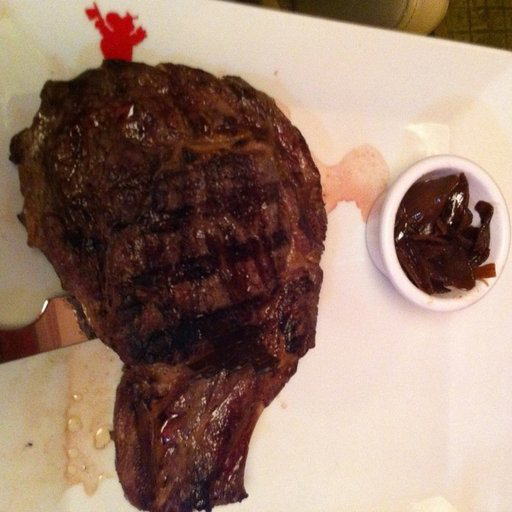

In [5]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name(the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")  
img


Text(0.5, 1.0, 'Image clss: steak | Shape: (512, 512, 3)')

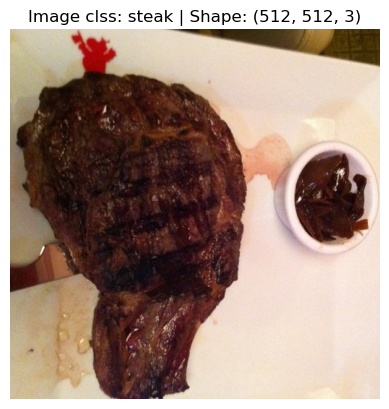

In [6]:
# Visualizing using matplotlib
import matplotlib.pyplot as plt
import numpy as np

img_array = np.array(img)

plt.imshow(img_array)
plt.axis(False)
plt.title(f"Image clss: {image_class} | Shape: {img_array.shape}")

### 3. Transforming data

*** Before use image data with PyTorch: ***
1. Turn data into tensors(in this case, numerical representation of images).
2. Turn it into ***torch.utils.data.Dataset*** and subsequently a ***torch.utils.data.DataLoader***, we'll call these **Dataset** and **DataLoader**.

In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### 3.1 Transforming data with torchvision.tranforms

In [8]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize images to 64x64
    transforms.Resize(size=(64, 64)),
    #Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [9]:
data_transform(img).shape

torch.Size([3, 64, 64])

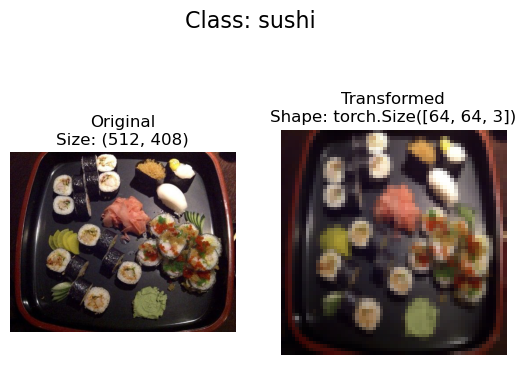

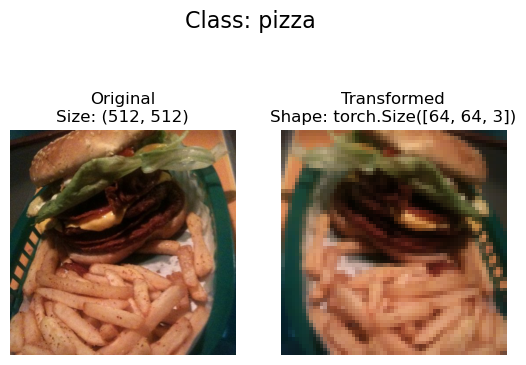

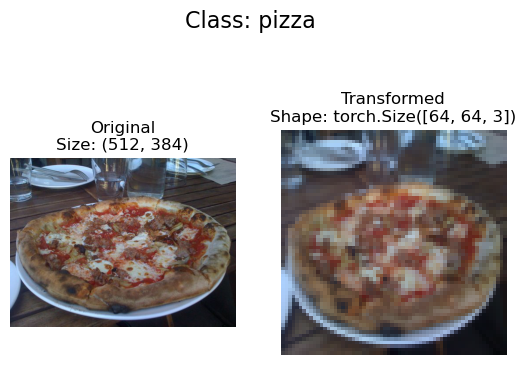

In [10]:
"""Selects random images from a path of images and loads/transforms
them them plots the original vs the transformed version."""

def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) # Need to change shape for matplotlib (C, H, W) -> (H, W, C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

### Option 1: Loading image data using ImageFolder

We can load image classification data using 'torchvision.datasets.ImageFolder'

In [11]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
# Check the length of dataset
len(train_data), len(test_data)

(225, 75)

In [15]:
# Index on the train_data Dataset to get a single image and label

img, label = train_data[0][0], train_data[0][1]

print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label/target: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

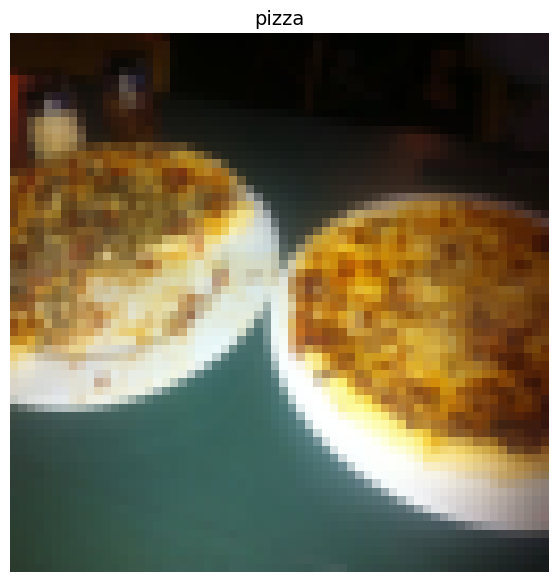

In [16]:
# Rearrange the order dimesions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

#### 4.1 Turn loaded images into `DataLoader's`

A `DataLoader` is going to help us turn Dataset's into iterable and can customize the `batch_size` so model can see `batch_size` imagese at a time.

In [17]:
# Turn train and test datasets into DataLoader'set
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1919f081850>,
 <torch.utils.data.dataloader.DataLoader at 0x1919f081460>)

In [18]:
len(train_dataloader), len(test_dataloader) 

(8, 3)

In [19]:
img, label = next(iter(train_dataloader))

# Batch size will now be 32
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


### 5 Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

In [20]:
import os
import pathlib

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

#### 5.1 Creating a helper function to get class names

***We want a function to:***
1. Get the class names using `os.scandir()` to traverse a target directory(ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found(if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [21]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted(entry.name for entry in list(os.scandir(target_directory)))
class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [22]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory."""
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")
    
    # 3. Create a directory of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

***To create our own custom dataset, we want to:***
1. Subclass `torch.utils.data.Dataset`.
2. Init our subclass with a target directory(the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image.
5. Overwrite the `__len()__` method to return the length of our dataset.
6. Overwrite `__getitem()__` method to return a given sample when passed an index.

In [23]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self,
                 targ_dir: str,
                 transform=None):
        # 3. Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

        # Setup transform
        self.transform = transform

        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len__()
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx  # return data, label (X, y)
        else:
            return img, class_idx  # return untransformed image and label


In [24]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [25]:
# Test out ImageFolderCustom

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1919f08fad0>,
 <__main__.ImageFolderCustom at 0x191a04ff050>)

In [26]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset

print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


#### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. Cap the number of images to see at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (height, width, color_channels).

In [27]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purpose, n shouldn't be larger than 10, setting to 10 and removing shape display")

    # 3. Setup the random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_sample_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0)  # height, width, color_channels

        # Plot adjusted sample
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nShape: {targ_image_adjust.shape}"
            plt.title(title)
    

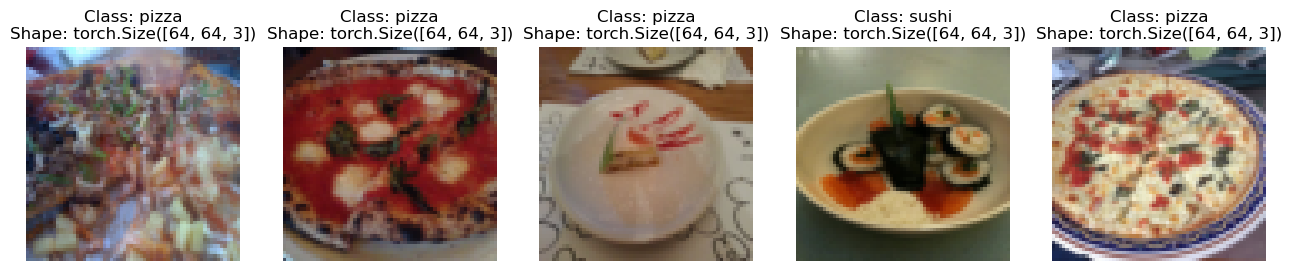

In [28]:
# Display random images from the ImageFolder created Dataset

display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purpose, n shouldn't be larger than 10, setting to 10 and removing shape display


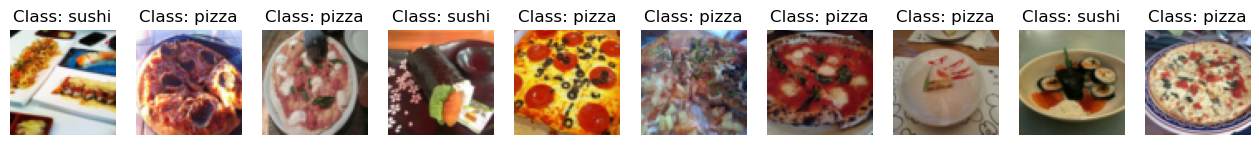

In [29]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom, 
                      n=20,
                      classes=class_names,
                      seed=42)

#### 5.4 Turn custom loaded images into `DataLoader's`

In [30]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x191a087b800>,
 <torch.utils.data.dataloader.DataLoader at 0x1919f0fd040>)

In [31]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape


(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### 6. Other forms of transforms (Data Augmentation)

In [32]:
# Let's look at trivailaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [33]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg')]

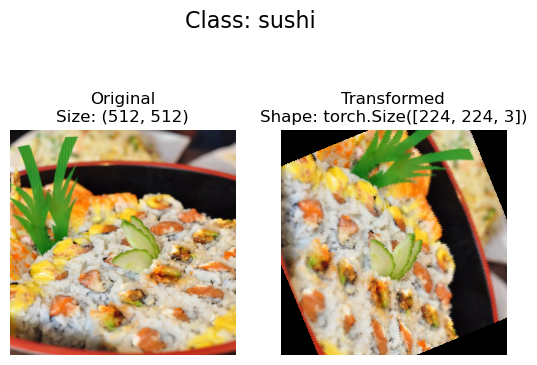

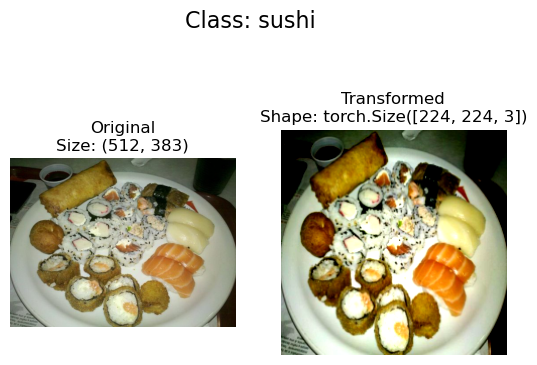

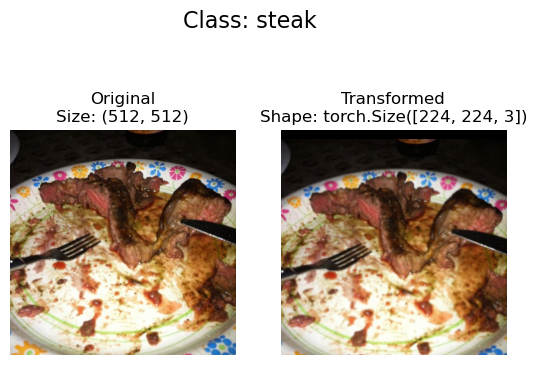

In [34]:
# Plot random transformed images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

### 7. Model 0: TinyVGG without data augmentation

#### 7.1 Creating transforms and loading data for Model 0

In [35]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [36]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform,
                                         target_transform=None)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoader
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = 0

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

#### 7.2 Create TinyVGG model class

In [37]:
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # Benifits from operator fusion

In [38]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3,  # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

#### 7.3 Try a forward pass on a single image (to test the model)

In [39]:
# Get a single image batch

image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [40]:
# Try a forward pass -> This is a trick to match the input size of final layer in classifier block
model_0(image_batch.to(device))


tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6317e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2869e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7293e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1838e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4455e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7724e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5022e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4219e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8254e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

#### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [41]:
# Install torchinfo, import if it's available

try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=(32, 3, 64, 64))  # batch_size, color_channels, height, width

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

#### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [42]:
# Create train_step()

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_function: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through dataloader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)  # output model logits

        # 2. Calculate the loss
        loss = loss_function(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_avg_loss = train_loss / len(dataloader)
    train_avg_acc = train_acc / len(dataloader)
    return train_avg_loss, train_avg_acc

In [43]:
# Create test_step()
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_function: torch.nn.Module,
              device=device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate the loss
            loss = loss_function(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += (test_pred_labels==y).sum().item()/len(test_pred_labels)

    # Adjust metrics to get average loss and accuracy per batch
    test_avg_loss = test_loss / len(dataloader)
    test_avg_acc = test_acc / len(dataloader)
    return test_avg_loss, test_avg_acc

#### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [44]:
import torch.optim.optimizer
from tqdm.auto import tqdm

# 1. Create a train function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_function: torch.nn.Module=nn.CrossEntropyLoss(),
          epochs: int=5,
          device=device):
    
    # 2. Create empty results
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_function=loss_function,
                                           optimizer=optimizer,
                                           device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_function=loss_function,
                                        device=device)
        
        # 4. Print out what's happening
        print(f"Epoch: {epoch}")
        print(f"Train loss: {train_loss: 4f} | Train acc: {train_acc: 4f}")
        print(f"Test loss: {test_loss: 4f} | Test acc: {test_acc: 4f}")

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    # 6. Return the filled results
    return results

c:\Users\GD\anaconda3\envs\envResearch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 7.7 Train and Evaluate model_0

In [45]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,  # No.of color_channels
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_function=loss_function,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()

print(f"Total training time: {end_time-start_time: .3f} seconds")

 20%|██        | 1/5 [00:05<00:21,  5.36s/it]

Epoch: 0
Train loss:  1.106343 | Train acc:  0.304688
Test loss:  1.098317 | Test acc:  0.290720


 40%|████      | 2/5 [00:08<00:12,  4.25s/it]

Epoch: 1
Train loss:  1.099527 | Train acc:  0.332031
Test loss:  1.069836 | Test acc:  0.541667


 60%|██████    | 3/5 [00:12<00:07,  3.87s/it]

Epoch: 2
Train loss:  1.086230 | Train acc:  0.492188
Test loss:  1.079936 | Test acc:  0.522727


 80%|████████  | 4/5 [00:15<00:03,  3.65s/it]

Epoch: 3
Train loss:  1.082340 | Train acc:  0.410156
Test loss:  1.060016 | Test acc:  0.572917


100%|██████████| 5/5 [00:18<00:00,  3.78s/it]

Epoch: 4
Train loss:  1.062856 | Train acc:  0.410156
Test loss:  1.060633 | Test acc:  0.553977
Total training time:  18.908 seconds


In [46]:
model_0_results

{'train_loss': [1.1063429564237595,
  1.0995267778635025,
  1.0862295478582382,
  1.0823403596878052,
  1.0628555119037628],
 'train_acc': [0.3046875, 0.33203125, 0.4921875, 0.41015625, 0.41015625],
 'test_loss': [1.0983171860376995,
  1.069835861523946,
  1.0799363056818645,
  1.06001615524292,
  1.060632546742757],
 'test_acc': [0.29071969696969696,
  0.5416666666666666,
  0.5227272727272728,
  0.5729166666666666,
  0.5539772727272728]}

#### 7.8 Plot the loss curves of Model_0

A **Loss Curve** is a way of tracking your model's progress over time.

In [47]:
# Get the model_0 results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [48]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary."""
    # Get the loss values of the results dictionary(training and test)
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results dictionary(training ant test)
    train_accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label="Train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


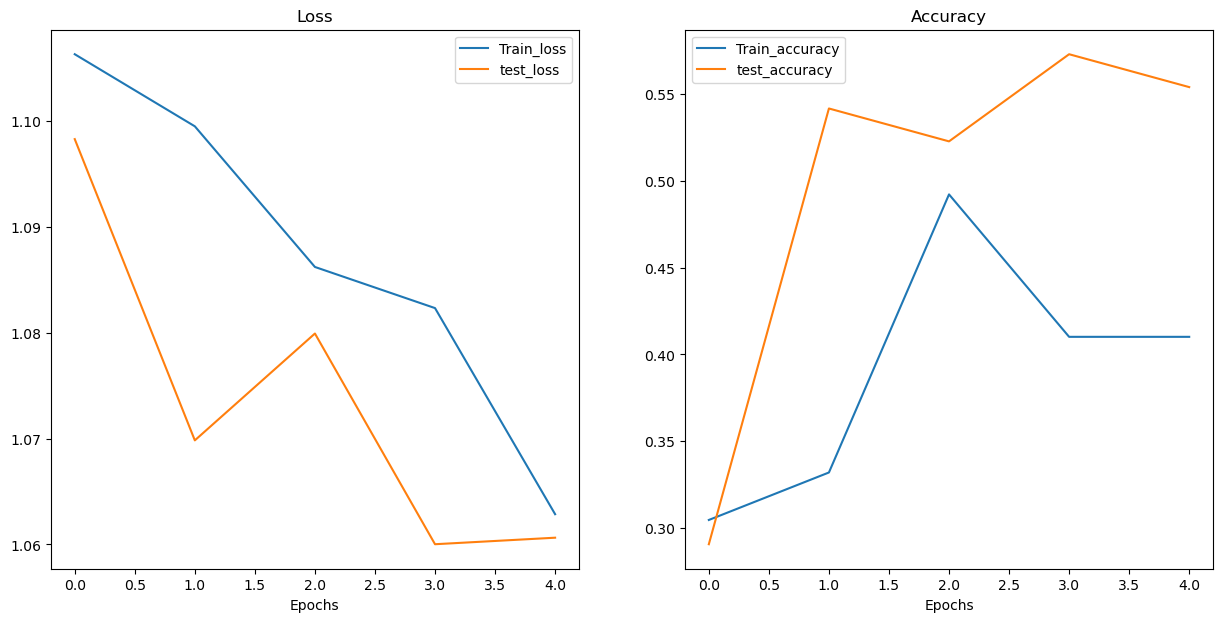

In [49]:
plot_loss_curves(model_0_results)

### 8. Model_1: TinyVGG wiht Data Augmentation

Try another modelling experiment using the same model as before with some data augmentation.

#### 8.1 Create transform with data augmentation

In [50]:
# Create training transform with TrivialAgument
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

#### 8.2 Create train and test `Dataset's` and `DataLoader's` with data augmentation

In [51]:
# Turn image folders into Datasets
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [52]:
# Turn Datasets into DataLoaders

BATCH_SIZE = 32
NUM_WORKERS = 0

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

#### 8.3 Construct and train model_1

This time using the same model architecture with ***augmented training data***

In [53]:
# Create model_1 and send it to the target device

torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,  # No.of color_channels
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [54]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 5

# Set loss function
loss_function = nn.CrossEntropyLoss()

# Set optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

In [55]:
# Start the timer
from timeit import default_timer as Timer

start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_function=loss_function,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out the model training time
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time: .3f} seconds.")

 20%|██        | 1/5 [00:03<00:14,  3.65s/it]

Epoch: 0
Train loss:  1.103595 | Train acc:  0.250000
Test loss:  1.100706 | Test acc:  0.260417


 40%|████      | 2/5 [00:07<00:10,  3.53s/it]

Epoch: 1
Train loss:  1.072532 | Train acc:  0.425781
Test loss:  1.141753 | Test acc:  0.260417


 60%|██████    | 3/5 [00:10<00:07,  3.55s/it]

Epoch: 2
Train loss:  1.142893 | Train acc:  0.304688
Test loss:  1.161940 | Test acc:  0.260417


 80%|████████  | 4/5 [00:14<00:03,  3.51s/it]

Epoch: 3
Train loss:  1.086238 | Train acc:  0.425781
Test loss:  1.102290 | Test acc:  0.260417


100%|██████████| 5/5 [00:17<00:00,  3.53s/it]

Epoch: 4
Train loss:  1.096869 | Train acc:  0.304688
Test loss:  1.087421 | Test acc:  0.260417
Total training time for model_1:  17.667 seconds.


#### 8.4 Plot the loss curvers of model_1

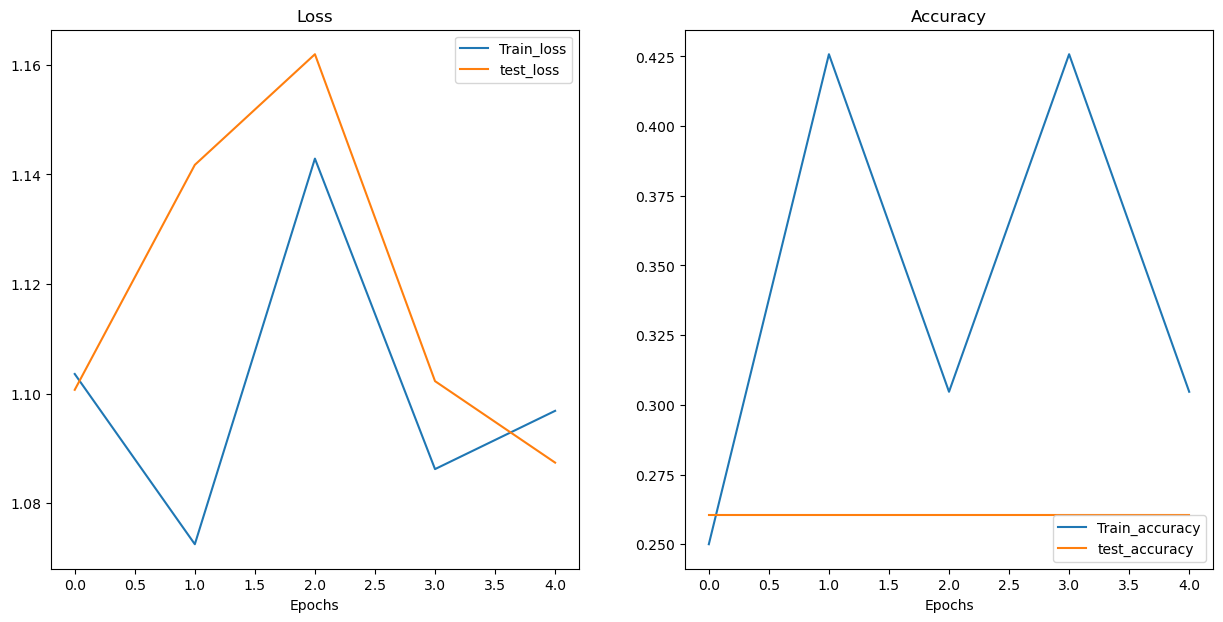

In [56]:
plot_loss_curves(model_1_results)

### 9. Compare model results

After evaluating modelling experiments on their own, it's important to compare them to each other.

There are few different ways to do this:

1. Hard coding (what we're doing)
2. PyTorch + Tensorboard 
3. Weights & Biases - https://wandb.ai/site/
4. MLFlow - https://mlflow.org/

In [57]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106343,0.304688,1.098317,0.290720
1,1.099527,0.332031,1.069836,0.541667
2,1.086230,0.492188,1.079936,0.522727
3,1.082340,0.410156,1.060016,0.572917
4,1.062856,0.410156,1.060633,0.553977


In [58]:
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.103595,0.250000,1.100706,0.260417
1,1.072532,0.425781,1.141753,0.260417
2,1.142893,0.304688,1.161940,0.260417
3,1.086238,0.425781,1.102290,0.260417
4,1.096869,0.304688,1.087421,0.260417


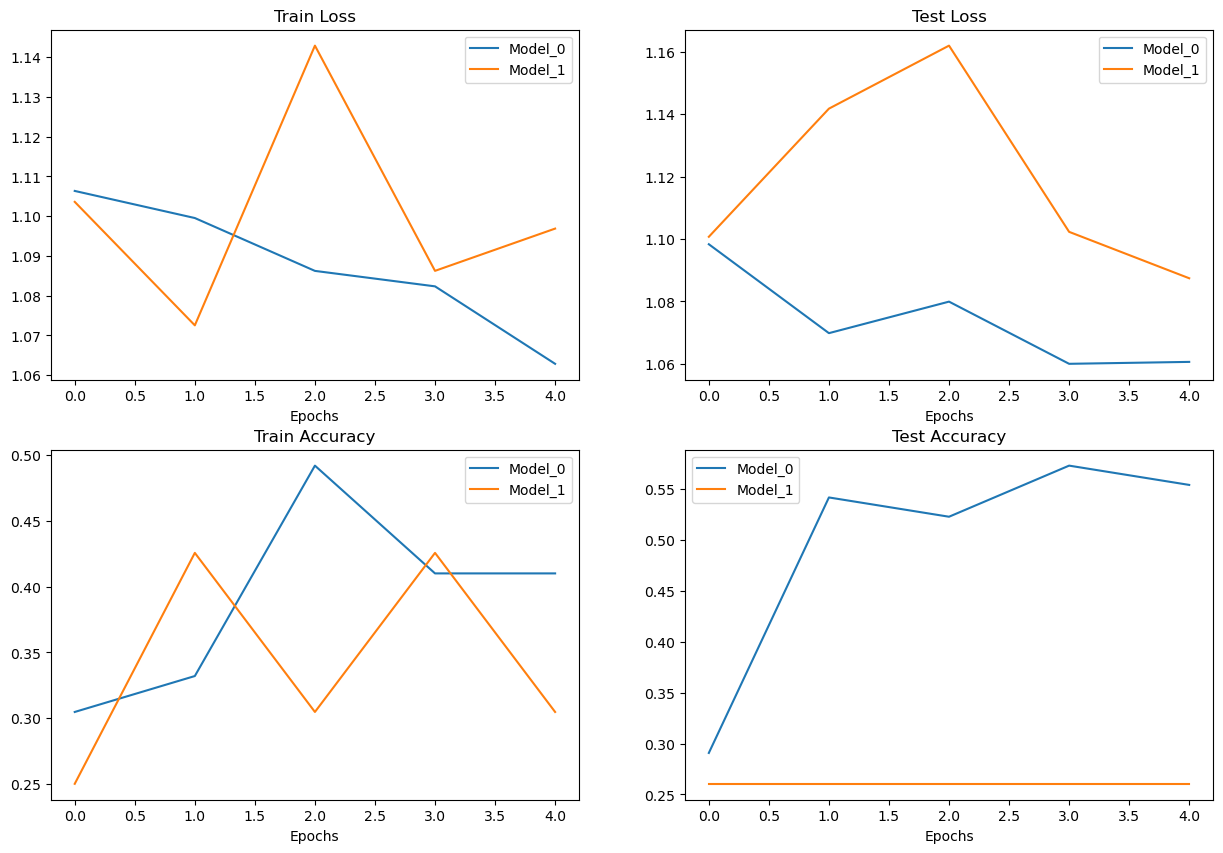

In [59]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model_0")
plt.plot(epochs, model_1_df["train_loss"], label="Model_1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model_0")
plt.plot(epochs, model_1_df["test_loss"], label="Model_1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model_0")
plt.plot(epochs, model_1_df["train_acc"], label="Model_1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model_0")
plt.plot(epochs, model_1_df["test_acc"], label="Model_1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

## 10. Making prediction on a custom image

In [60]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "pizza-custom.png"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as file:
        request = requests.get("https://images.app.goo.gl/ALH9LaZacsmFpVcD7")
        print(f"Downloading {custom_image_path}...")
        file.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download...")

data\pizza-custom.png already exists, skipping download...


#### 10.1 Loading in a custom image with PyTorch

When have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (torch.float32)
* Of shape 3x64x64
* On the right device

In [64]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(f"Custom image tensor:\n{custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[237, 236, 238,  ..., 233, 232, 232],
         [241, 239, 239,  ..., 233, 233, 233],
         [238, 236, 237,  ..., 234, 235, 235],
         ...,
         [221, 218, 213,  ..., 219, 219, 218],
         [224, 221, 215,  ..., 219, 218, 218],
         [227, 226, 219,  ..., 218, 217, 216]],

        [[237, 236, 238,  ..., 233, 232, 232],
         [241, 239, 239,  ..., 233, 233, 233],
         [238, 236, 237,  ..., 234, 235, 235],
         ...,
         [221, 218, 213,  ..., 219, 219, 218],
         [224, 221, 215,  ..., 219, 218, 218],
         [227, 226, 219,  ..., 218, 217, 216]],

        [[237, 236, 238,  ..., 233, 232, 232],
         [241, 239, 239,  ..., 233, 233, 233],
         [238, 236, 237,  ..., 234, 235, 235],
         ...,
         [221, 218, 213,  ..., 219, 219, 218],
         [224, 221, 215,  ..., 219, 218, 218],
         [227, 226, 219,  ..., 218, 217, 216]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 270, 270])
Custom image datatyp

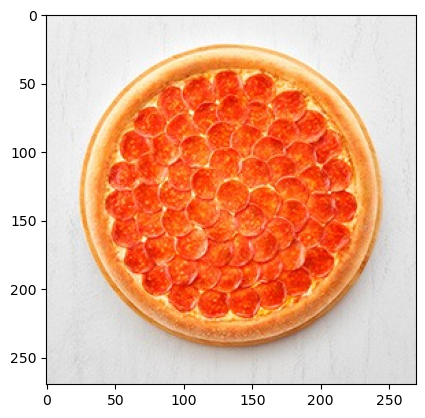

In [63]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

#### 10.2 Making a prediction on a custom image with a trained PyTorch model

***Note*** :- to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* ***Wrong datatype*** - Make sure the image was the same datatype as the model (torch.float32)
* ***Wrong size*** - Make sure the image was the same shape as the data which the model was trained on (3, 64, 64) with a batch size... (1, 3, 64, 64)
* ***Wrong device*** - Make sure the image was on the same device as our model


In [69]:
# Convert image to torch.float32
custom_image_float32 = custom_image_uint8.type(torch.float32)

# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image_float32)

# Adding a batch size 
custom_image_unsqueeze = custom_image_transformed.unsqueeze(0)

# Put custom image to device
custom_image_device = custom_image_unsqueeze.to(device)

# Print the shapes
print(f"Original shape: {custom_image_float32.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")
print(f"Added batch size shape: {custom_image_unsqueeze.shape}")
print(f"Device of custom data: {custom_image_device.device}")

Original shape: torch.Size([3, 270, 270])
Transformed shape: torch.Size([3, 64, 64])
Added batch size shape: torch.Size([1, 3, 64, 64])
Device of custom data: cuda:0


In [70]:
# Make prediction with custom data
model_1.eval()

with torch.inference_mode():
    custom_image_pred = model_1(custom_image_device)

custom_image_pred

tensor([[  4.7312, -12.4518,  -1.0811]], device='cuda:0')

In [71]:
# Convert logits -> Prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[9.9702e-01, 3.4372e-08, 2.9815e-03]], device='cuda:0')

In [73]:
# Convert prediction probabilities -> Prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [74]:
class_names[custom_image_pred_label]

'pizza'

#### 10.3 Creating a function to custom image prediction

A function where pass an image path to and have our model predict on that image and plot the image + prediction

In [77]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str]=None,
                        transform=None,
                        device=device):
    # Load the image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255

    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Add batch dimension(extra dimension)
    target_image = target_image.unsqueeze(0)

    # Make sure the model is on the target device
    model.to(device)

    # Turn on evel/inference mode and make a prediction
    model.eval()
    with torch.inference_mode():
        # Make prediction on image with extra dimension
        target_image_preds = model(target_image.to(device)) # Make sure the target_image is on the right device

    # Convert logits -> Prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_preds, dim=1)

    # Convert prediction probabilities -> Prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot the alongside the prediction and prediction probabiity
    plt.imshow(target_image.squeeze().permute(1, 2, 0))  # Remove batch dimension and rearrange shapes suitable for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label]} | Probs: {target_image_pred_probs.max().cpu(): .3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu(): .3f}"
    plt.title(title)
    plt.axis(False)

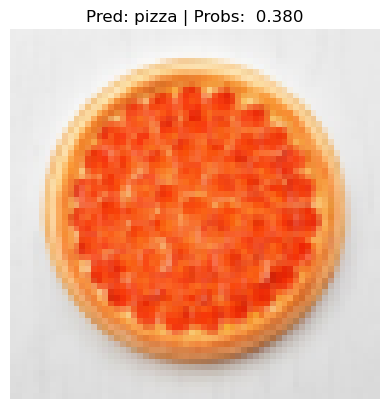

In [85]:
# Pred on custom image

pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)